In [1]:
import pandas as pd # for handling dataframes in python
import numpy as np # array handling
import getopt, sys
import os



#################################
######## Load iNat Data #########
#################################
print("Loading iNaturalist data...")
# read file name
iNat = pd.read_csv("/net/scratch/swolf/iNat_111122/0158753-220831081235567.csv", sep='\t')

iNat = iNat[["gbifID", "scientificName","decimalLatitude","decimalLongitude",
            "eventDate", "dateIdentified"]]

iNat['scientificName']  = iNat['scientificName'].apply(lambda x: ' '.join(x.split()[0:2]))

#iNat.to_csv("Data/iNat/observations.csv", index=False)

Loading iNaturalist data...


In [ ]:
#################################
###### TRY summary stats ########
#################################

print("Preprocessing TRY data...")
TRYdata = pd.read_csv("/net/scratch/swolf/TRY_gdvm/23608.txt", sep = "\t", encoding="iso-8859-1",
                     usecols = ["AccSpeciesName", "SpeciesName", "TraitID", "TraitName", "StdValue"],
                     dtype={'TraitID': float})

# make all letters lower case
TRYdata['AccSpeciesName'] = TRYdata['AccSpeciesName'].str.lower()
# capitalize first letter in string
TRYdata['AccSpeciesName'] = TRYdata['AccSpeciesName'].str.capitalize()
# get only two first words (split at space)
TRYdata['AccSpeciesName']  = TRYdata['AccSpeciesName'].apply(lambda x: ' '.join(x.split()[0:2]))
# change type to string
TRYdata['AccSpeciesName'] = TRYdata['AccSpeciesName'].astype(str)

# same for species name
TRYdata['SpeciesName'] = TRYdata['SpeciesName'].str.lower()
TRYdata['SpeciesName'] = TRYdata['SpeciesName'].str.capitalize()
TRYdata['SpeciesName'] = TRYdata['SpeciesName'].astype(str)
TRYdata['SpeciesName']  = TRYdata['SpeciesName'].apply(lambda x: ' '.join(x.split()[0:2]))

# group data by species name and trait
grouped = TRYdata.groupby(['AccSpeciesName', 'TraitID', 'TraitName'])
TRYsummary = grouped['StdValue'].agg([np.mean]).reset_index()


In [ ]:
TRYsummary.columns

In [ ]:
def shorten_names(df):

    df.rename(columns = {'Stem specific density (SSD) or wood density (stem dry mass per stem fresh volume)':'SSD'}, inplace = True)
    df.rename(columns = {'Leaf carbon (C) content per leaf dry mass':'Leaf C'}, inplace = True)
    df.rename(columns = {'Leaf nitrogen (N) content per leaf dry mass':'Leaf N per mass'}, inplace = True)
    df.rename(columns = {'Leaf phosphorus (P) content per leaf dry mass':'Leaf P'}, inplace = True)
    df.rename(columns = {'Leaf dry mass per leaf fresh mass (leaf dry matter content, LDMC)':'LDMC'}, inplace = True)
    df.rename(columns = {'Seed dry mass':'Seed mass'}, inplace = True)
    df.rename(columns = {'Seed length':'Seed length'}, inplace = True)
    df.rename(columns = {'Leaf nitrogen (N) content per leaf area':'Leaf N per area'}, inplace = True)
    df.rename(columns = {'Leaf nitrogen/phosphorus (N/P) ratio':'Leaf N P ratio'}, inplace = True)
    df.rename(columns = {'Leaf nitrogen (N) isotope signature (delta 15N)':'Leaf delta15N'}, inplace = True)
    df.rename(columns = {'Leaf fresh mass':'Leaf fresh mass'}, inplace = True)
    df.rename(columns = {'Seed number per reproducton unit':'Seeds per rep. unit'}, inplace = True)
    df.rename(columns = {'Stem conduit density (vessels and tracheids)':'Stem conduit density'}, inplace = True)
    df.rename(columns = {'Dispersal unit length':'Dispersal unit length'}, inplace = True)
    df.rename(columns = {'Wood vessel element length; stem conduit (vessel and tracheids) element length':'Conduit element length'}, inplace = True)
    df.rename(columns = {'Plant height vegetative':'Plant Height'}, inplace = True)
    df.rename(columns = {'Leaf area (in case of compound leaves: leaflet, undefined if petiole is in- or excluded)':'Leaf Area'}, inplace = True)
    df.rename(columns = {'Leaf area per leaf dry mass (specific leaf area, SLA or 1/LMA): undefined if petiole is in- or excluded':'SLA'}, inplace = True)

TRY = TRYsummary.pivot(index=["AccSpeciesName"], columns="TraitName", values="mean")

# reset indeces (species name) as columns in data frame
TRY.reset_index(inplace=True)


#########TRYsummary_t.to_csv("TRY/TRY_summary_stats.csv", index=False)

# same with original TRY name
# group data by species name and trait, same analysis as above
grouped_syn = TRYdata.groupby(['SpeciesName', 'TraitID', 'TraitName'])

TRYsummary_syn = grouped_syn['StdValue'].agg([np.mean]).reset_index()

# change df shape
TRY_syn = TRYsummary_syn.pivot(index=["SpeciesName"], columns="TraitName", values="mean")

# reset indeces (species name) as columns in data frame
TRY_syn.reset_index(inplace=True)

# shorten column names
shorten_names(TRY_syn)

#TRYsummary_t_syn.to_csv("TRY/TRY_summary_stats_syn.csv", index=False)




In [ ]:
############################################
######## Link iNaturalist and TRY ##########
############################################

print("Linking iNaturalist and TRY...")

iNat_TRY = pd.merge(iNat, TRY,
                    left_on= ['scientificName'],
                    right_on= ['AccSpeciesName'],
                    how='inner')

# filter for observations not in merged dataframe:
iNat_rest = iNat[~iNat.gbifID.isin(iNat_TRY['gbifID'])]

# non-fuzzy merge with TRY summary stats on original TRY species name:

iNat_TRY_syn = pd.merge(iNat_rest, TRY_syn,
                    left_on= ['scientificName'],
                    right_on= ['SpeciesName'],
                    how='inner')

subsets = [iNat_TRY, iNat_TRY_syn]

iNat_TRY_all = pd.concat(subsets)
iNat_TRY_all = iNat_TRY_all.drop(['AccSpeciesName', 'SpeciesName'], axis = 1)

trait = iNat_TRY_all.columns[6:24]

iNat_TRY_all = iNat_TRY_all.replace(-np.inf, np.nan)
iNat_TRY_all = iNat_TRY_all.replace(np.inf, np.nan)

iNat_TRY_all.loc[:, trait] = np.log(iNat_TRY_all[trait])

print("Exporting linked iNaturalist-TRY data frame to csv...")
iNat_TRY_all.to_csv("/net/scratch/swolf/TRY_gdvm/iNat_TRY_dgvm_log.csv", index=False)


In [ ]:
%%R

###########################
##### make GeoTiffs #######
###########################

library(raster)

# Load iNat Data
print("Load iNaturalist-TRY data in R...")
iNat <- read.csv("/net/scratch/swolf/TRY_gdvm/iNat_TRY_dgvm_log.csv")
xy <- cbind(iNat$decimalLongitude, iNat$decimalLatitude)

# raster for a 0.5 and 2 degree resolution map
r05 <- raster(ncols = 720, nrows = 360)
r2 <- raster(ncols = 180, nrows = 90)



In [6]:
%R print(colnames(iNat))

 [1] "gbifID"                                                                                                 
 [2] "scientificName"                                                                                         
 [3] "decimalLatitude"                                                                                        
 [4] "decimalLongitude"                                                                                       
 [5] "eventDate"                                                                                              
 [6] "dateIdentified"                                                                                         
 [7] "Leaf.area.per.leaf.dry.mass..specific.leaf.area..SLA.or.1.LMA...petiole.excluded"                       
 [8] "Leaf.area.per.leaf.dry.mass..specific.leaf.area..SLA.or.1.LMA...petiole.included"                       
 [9] "Leaf.area.per.leaf.dry.mass..specific.leaf.area..SLA.or.1.LMA...undefined.if.petiole.is.in..or.excluded"
[

'gbifID','scientif...,'decimalL...,...,'Xylem.hy...,'SLA','Plant.He...


[1] "Genereate 2 degree maps..."
[1] "Genereate 0.5 degree maps..."


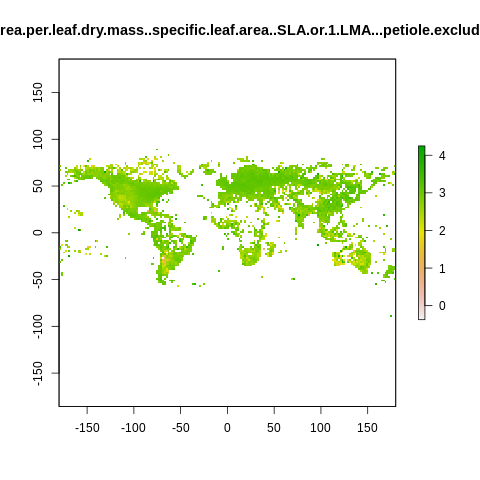

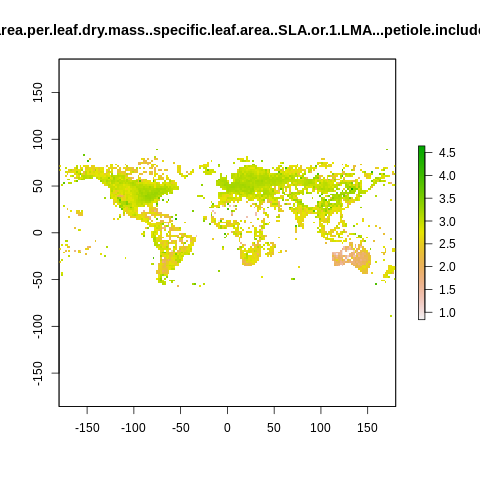

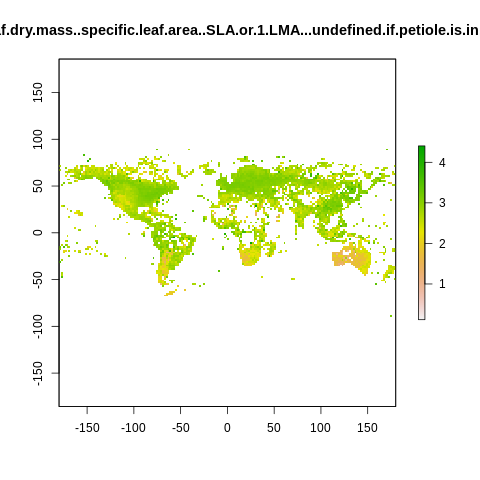

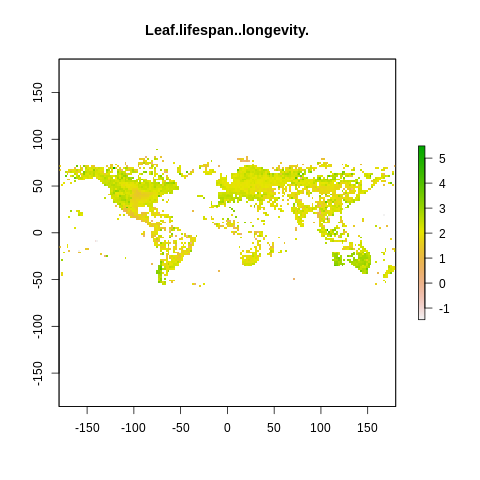

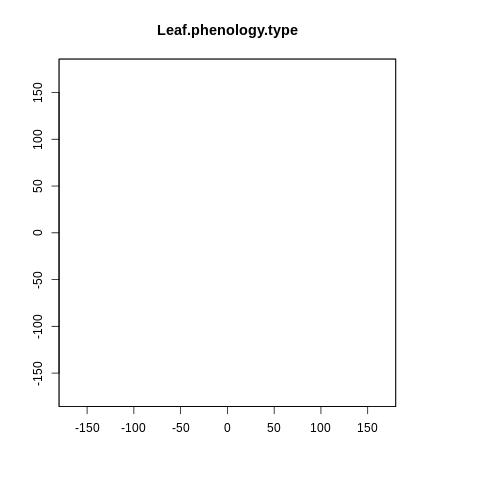

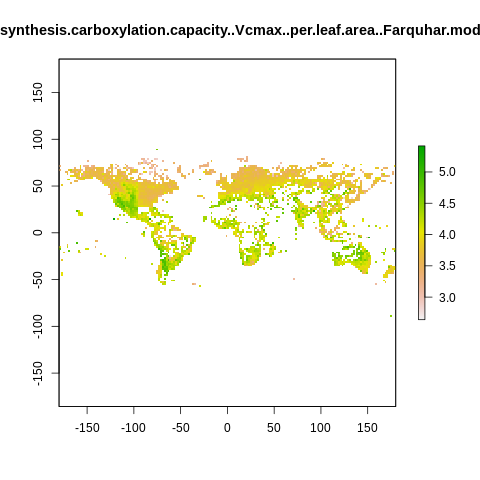

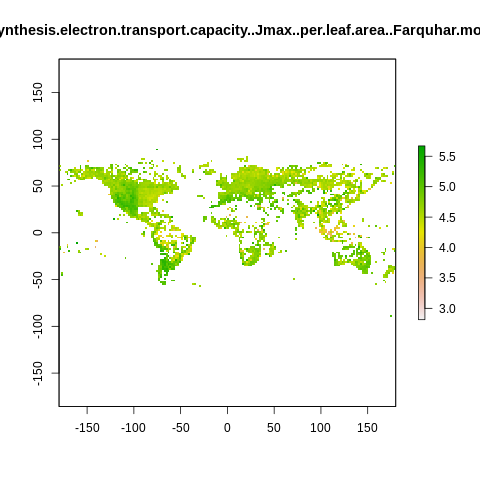

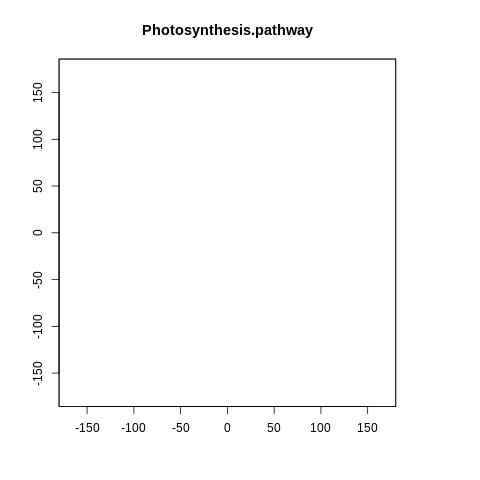

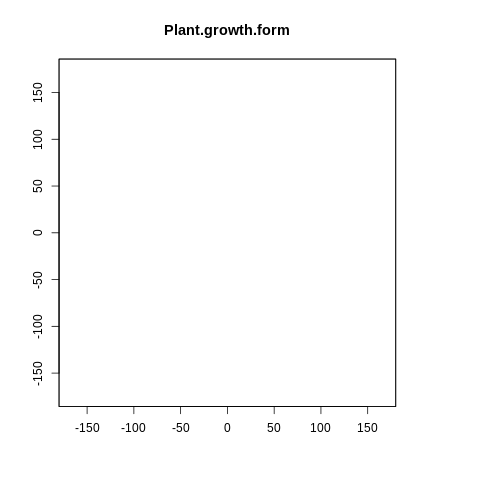

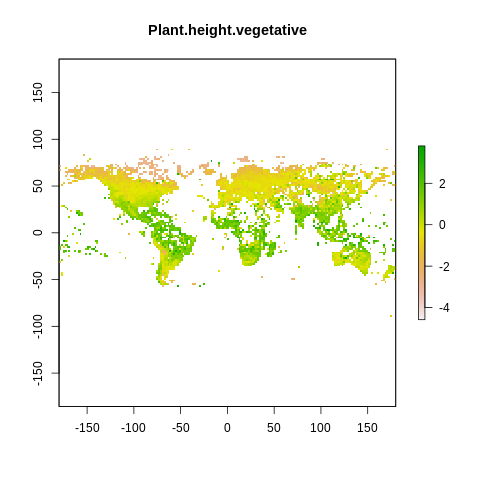

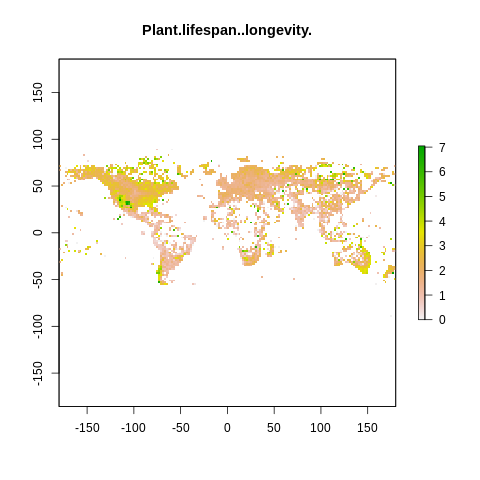

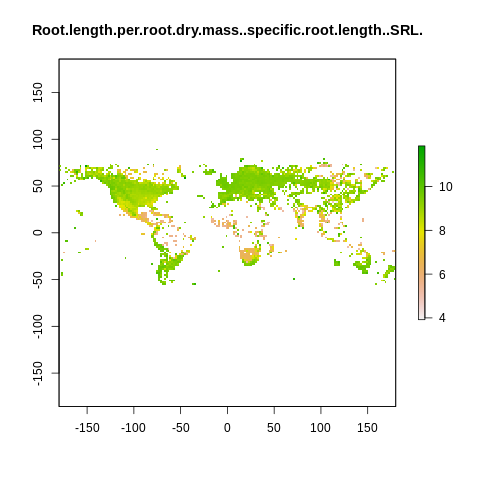

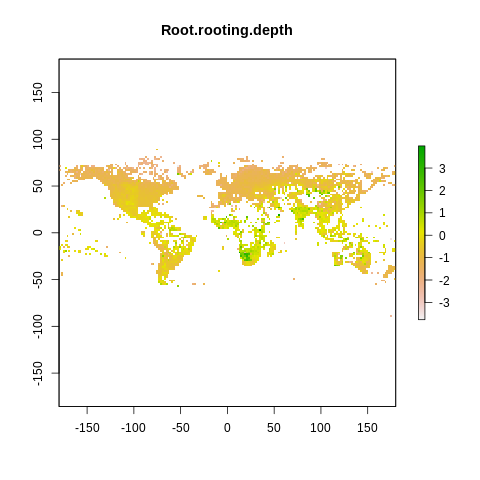

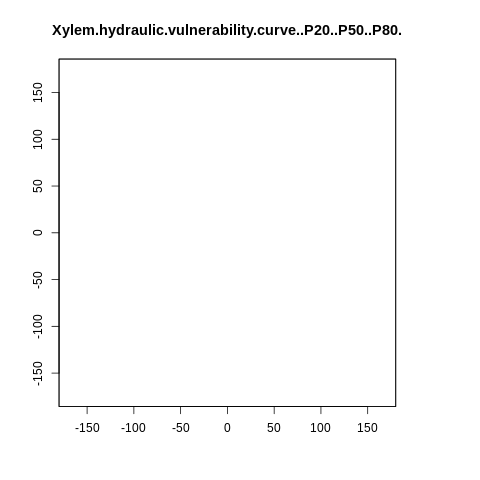

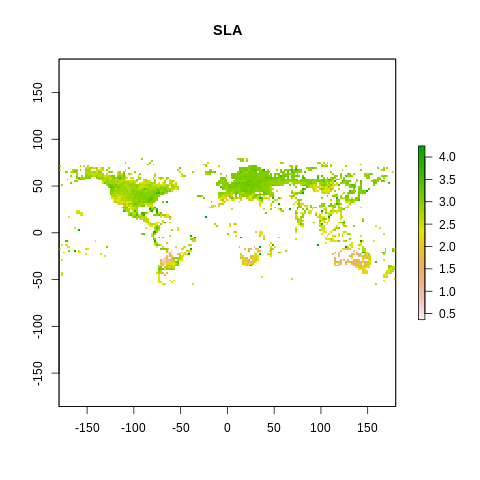

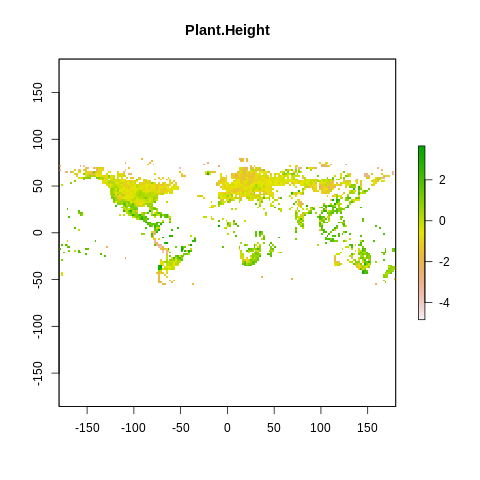

In [9]:
%%R

loop.vector <- 7:22 # loop over trait columns in sPlotOpen dataframe

# export exp(ln()) maps
print("Genereate 2 degree maps...")
for (i in loop.vector) { # Loop over loop.vector
  vals <- iNat[,i]
  name <- colnames(iNat[i])

  # 2 ln
  raster2 <- rasterize(xy, r2, vals, fun = mean)
  raster2[is.infinite(raster2)] <- NA
  crs(raster2) <- "+proj=longlat"
  filename = paste("iNat_", name, "_2deg_ln.tif", sep="")
  writeRaster(raster2,filename, overwrite=TRUE)

  plot(raster2, main=name)
    
  # 2 exp
  raster2 <- exp(raster2)
  filename = paste("iNat_", name, "_2deg_expln.tif", sep="")
  writeRaster(raster2,filename, overwrite=TRUE)


}

print("Genereate 0.5 degree maps...")
for (i in loop.vector) { # Loop over loop.vector
  vals <- iNat[,i]
  name <- colnames(iNat[i])

  # 0.5 ln
  raster05 <- rasterize(xy, r05, vals, fun = mean)
  raster05[is.infinite(raster05)] <- NA
  crs(raster05) <- "+proj=longlat"
  filename = paste("iNat_", name, "_05deg_ln.tif", sep="")
  writeRaster(raster05,filename, overwrite=TRUE)

  # 0.5 exp
  raster05 <- exp(raster05)
  filename = paste("iNat_", name, "_05deg_expln.tif", sep="")
  writeRaster(raster05,filename, overwrite=TRUE)

}

## Make sPlot traitmaps

In [2]:
%load_ext rpy2.ipython

In [4]:
%%R

library(raster)
library(data.table)
#Load Data

dtn = 30
setDTthreads(threads = dtn)

file <- "/net/scratch/swolf/GDVM/sPlot_gdvm/sPlotOpen_TRY23608_cwm.csv" #sPlotOpen gap-filled trait maps

data <- fread(file)
#data <- read.csv(file)

head(data)
xy <- cbind(data$Longitude, data$Latitude)

# raster for a 2 degree resolution map
#r02 <- raster(ncols = 1800, nrows = 900)
r05 <- raster(ncols = 720, nrows = 360)
r2 <- raster(ncols = 180, nrows = 90)

rasters <- c(r05, r2)
loop.vector <- 2:11 # loop over these trait columns in dataframe
folder_name <- c("05deg","2deg")
#folder_name <- c("05deg")

index <- 1
for (j in rasters) {
  
  for (i in loop.vector) { # Loop over loop.vector
    vals <- data[,i, with=FALSE]
    name1 <- colnames(data[,i, with=FALSE])
    r1 <- rasterize(xy, j, vals, fun = mean)
    r1[is.infinite(r1)] <- NA
    crs(r1) <- "+proj=longlat"
    
    #export as GeoTiff -->  separate file for each trait
    
    filename1 = paste("/net/scratch/swolf/GDVM/traitmaps/", folder_name[index],  "/sPlotOpen_TRY23608_", name1, "_", folder_name[index], ".tif", sep="")
    print(filename1)
    writeRaster(r1, filename1, overwrite=TRUE)
  }
  
  index <- index +1
}  


[1] "/net/scratch/swolf/GDVM/traitmaps/05deg/sPlotOpen_TRY23608_SLA petiole excluded_05deg.tif"
[1] "/net/scratch/swolf/GDVM/traitmaps/05deg/sPlotOpen_TRY23608_SLA petiole included_05deg.tif"
[1] "/net/scratch/swolf/GDVM/traitmaps/05deg/sPlotOpen_TRY23608_SLA petiole undefined_05deg.tif"
[1] "/net/scratch/swolf/GDVM/traitmaps/05deg/sPlotOpen_TRY23608_Leaf lifespan (longevity)_05deg.tif"
[1] "/net/scratch/swolf/GDVM/traitmaps/05deg/sPlotOpen_TRY23608_Vcmax_05deg.tif"
[1] "/net/scratch/swolf/GDVM/traitmaps/05deg/sPlotOpen_TRY23608_Jmax_05deg.tif"
[1] "/net/scratch/swolf/GDVM/traitmaps/05deg/sPlotOpen_TRY23608_Plant height_05deg.tif"
[1] "/net/scratch/swolf/GDVM/traitmaps/05deg/sPlotOpen_TRY23608_Plant lifespan (longevity)_05deg.tif"
[1] "/net/scratch/swolf/GDVM/traitmaps/05deg/sPlotOpen_TRY23608_SRL_05deg.tif"
[1] "/net/scratch/swolf/GDVM/traitmaps/05deg/sPlotOpen_TRY23608_Root rooting depth_05deg.tif"
[1] "/net/scratch/swolf/GDVM/traitmaps/2deg/sPlotOpen_TRY23608_SLA petiole excluded_2d